In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D
from qcc.experiment import Experiment
from qcc.ml.model import Model

from pathlib import Path
from qcc.file import new_dir

# from qcc.quantum.pennylane.ansatz import ConvolutionPoolingAnsatz as Module
from qcc.quantum.pennylane.ansatz import BaselineAnsatz as Module

# from qcc.quantum.pennylane.ansatz.basic import BasicFiltering6
from qcc.quantum.pennylane.fully_connected import FullyConnected
from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter

INFO:qcc.ml.ml:Using CUDA on device cuda


In [3]:
# Meta parameters
name = "test"
path = Path(f"results/{name}")
num_trials = 10
silent = False
is_quantum = True

# Ansatz parameters
dims = (16, 16)
num_layers = 3
module_options = {
    # "U_filter": ConvolutionComplexAngleFilter,
    # "pre_op": True,
    # "U_fully_connected": None,
    # "pooling": False,
    # "filter_shape": (2, 2, 2),
}

INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 58
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 204
2023-08-24 14:40:29,843: (baselineansatz) Circuit ID: test
2023-08-24 14:40:29,843: (baselineansatz) module=BaselineAnsatz()
2023-08-24 14:40:29,843: (baselineansatz) data=BinaryData(dataset=<class 'torchvision.datasets.mnist.FashionMNIST'>, transform=image_transform, target_transform=None, batch_size=(8, 1000), classes=[0, 1])
2023-08-24 14:40:29,844: (baselineansatz) optimizer=<class 'torch.optim.adam.Adam'>, self.args=(), self.kwargs={}
2023-08-24 14:40:29,844: (baselineansatz) loss=CrossEntropyLoss()
2023-08-24 14:40:29,845: (baselineansatz) num_trials=10
2023-08-24 14:40:29,845: (baselineansatz) dims=(16, 16)
2023-08-24 14:40:29,846: (baselineansatz) num_layers=3
2023-08-24 14:40:29,846: (baselineansatz) module_options={}


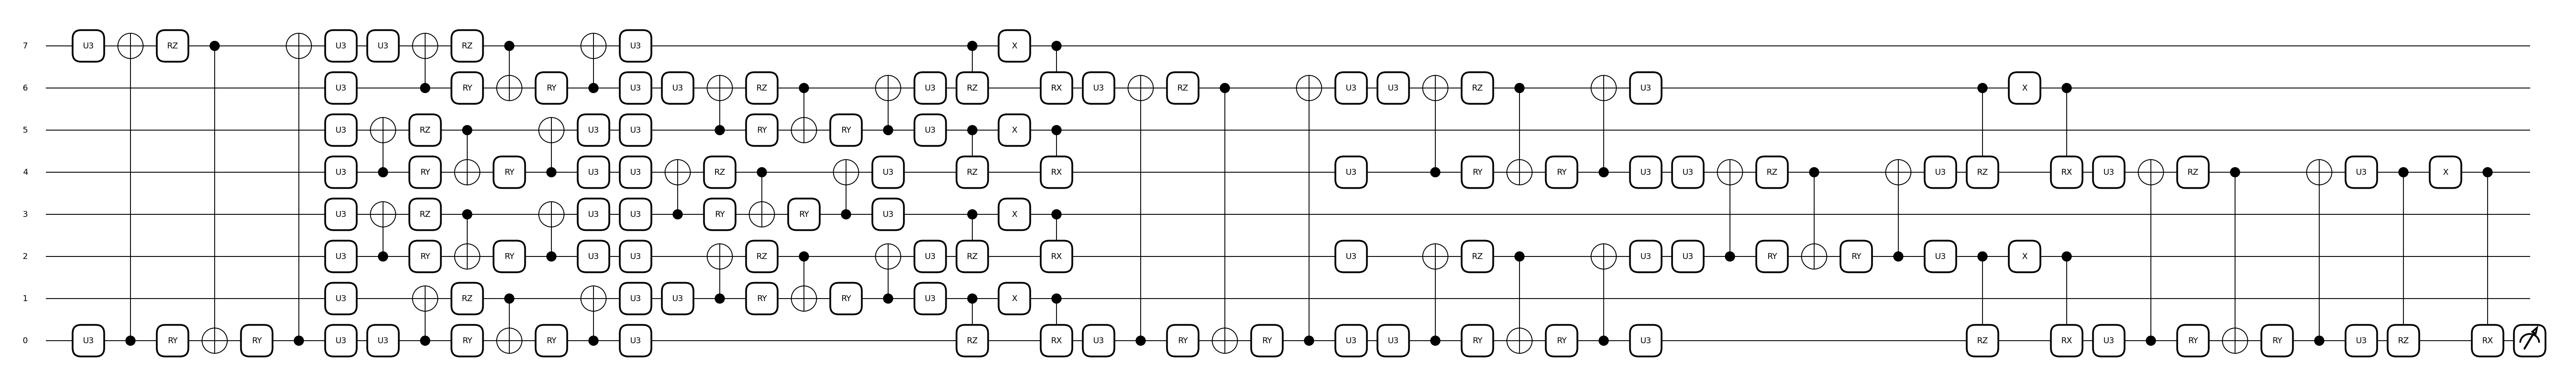

In [4]:
path = new_dir(path, overwrite=True)
if is_quantum:
    module = Module.from_dims
else:
    module = Module

# Create module
module = module(
    dims,
    num_layers=num_layers,
    **module_options,
)
data = BinaryData(
    FashionMNIST,
    ImageTransform(dims),
    batch_size=(8,1000),
)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
model = Model.with_logging(module, data, optimizer, loss, epoch=2)

# Log important values
model.logger.info(f"Circuit ID: {name}")
model.logger.info(f"{module=}")
model.logger.info(f"{data=}")
model.logger.info(f"{optimizer=}")
model.logger.info(f"{loss=}")

model.logger.info(f"{num_trials=}")
model.logger.info(f"{dims=}")
model.logger.info(f"{num_layers=}")
# model.logger.info(f"{1=}")
model.logger.info(f"{module_options=}")

# Save circuit drawing
if is_quantum:
    filename = path / f"{name}_circuit.png"
    module.draw(filename=filename, decompose=True)

In [5]:
# Run experiment
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema)
# experiment.partial(silent=silent)
results = experiment(filename=path / name)

# Print accuracy results
metrics = ("median", "mean", "max", "min", "std")
for name in results.columns:
    col = results[name]
    msg = (f"{metric}={getattr(col, metric)():.05}" for metric in metrics)
    msg = ", ".join(msg)
    msg = f"{name}: {msg}"
    model.logger.info(msg)

# Save aggregated loss history figure
display(experiment.draw(path / f"{name}.png"))

ValueError: dictionary update sequence element #0 has length 16; 2 is required